## Creaing a Correlation map between t2m and 500hPa during the specific CAO dates

In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4 as nc

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import matplotlib as mpl
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import time
import warnings

import scipy.stats

warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
#These are the specific dates from Smith 2015 within the month of jan that are relevant to the time period in dataset
#Turning them into datetime format

specific_dates = ['1981-01-07','1982-01-06','1984-01-13','1985-01-29','1988-01-04','1989-01-31','1994-01-12','1996-01-25','2010-01-02', 
                  '1979-02-05','1980-02-26','2007-02-01','2015-02-12',
                 '1983-12-14','1985-12-13','1989-12-11', '1995-12-07', '2000-12-17','2000-12-29','2005-12-01']
cao_dates = pd.to_datetime(specific_dates)
cao_dates_sorted = cao_dates.sort_values()
cao_dates_sorted

DatetimeIndex(['1979-02-05', '1980-02-26', '1981-01-07', '1982-01-06',
               '1983-12-14', '1984-01-13', '1985-01-29', '1985-12-13',
               '1988-01-04', '1989-01-31', '1989-12-11', '1994-01-12',
               '1995-12-07', '1996-01-25', '2000-12-17', '2000-12-29',
               '2005-12-01', '2007-02-01', '2010-01-02', '2015-02-12'],
              dtype='datetime64[ns]', freq=None)

In [5]:
#Opening 500hPa dataset

file1 = "/scratch/kbarrag/clim680_dataset/mean/erai.z500.day.mean.1979-2019.nc"
ds_500 = xr.open_dataset(file1)
ds_500

<xarray.Dataset>
Dimensions:  (lon: 512, lat: 128, time: 14853)
Coordinates:
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-08-31
Data variables:
    z500     (time, lat, lon) float32 ...

In [6]:
#Selecting the location on the map that we are interested in: North America
ds_500 = ds_500.sel(lon=slice(360-180,360-0))
ds_500

<xarray.Dataset>
Dimensions:  (lon: 256, lat: 128, time: 14853)
Coordinates:
  * lon      (lon) float64 180.0 180.7 181.4 182.1 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-08-31
Data variables:
    z500     (time, lat, lon) float32 ...

In [7]:
#Creating the climatology for the 500hPa dataset

ds_climo_500 = ds_500.groupby('time.dayofyear').mean()
ds_climo_500


<xarray.Dataset>
Dimensions:    (lon: 256, lat: 128, dayofyear: 366)
Coordinates:
  * lon        (lon) float64 180.0 180.7 181.4 182.1 ... 357.2 357.9 358.6 359.3
  * lat        (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Data variables:
    z500       (dayofyear, lat, lon) float32 5.742e+04 5.741e+04 ... 5.015e+04

In [8]:
#Creating the anomalies for the 500hPa dataset
ds_500_anoms= ds_500.groupby('time.dayofyear')- ds_climo_500
ds_500_anoms

<xarray.Dataset>
Dimensions:    (lon: 256, lat: 128, time: 14853)
Coordinates:
  * lon        (lon) float64 180.0 180.7 181.4 182.1 ... 357.2 357.9 358.6 359.3
  * lat        (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-08-31
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 236 237 238 239 240 241 242 243
Data variables:
    z500       (time, lat, lon) float32 11.98 18.73 24.37 ... 766.3 766.6 766.6

In [9]:
#using the specific cao dates and selecting them from the anomaly dataset
#These are the onset day. 

da_500_anoms_cao= ds_500_anoms.sel(time=cao_dates_sorted)
da_500_anoms_cao

<xarray.Dataset>
Dimensions:    (lon: 256, lat: 128, time: 20)
Coordinates:
  * lon        (lon) float64 180.0 180.7 181.4 182.1 ... 357.2 357.9 358.6 359.3
  * lat        (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * time       (time) datetime64[ns] 1979-02-05 1980-02-26 ... 2015-02-12
    dayofyear  (time) int64 36 57 7 6 348 13 29 347 ... 25 352 364 335 32 2 43
Data variables:
    z500       (time, lat, lon) float32 6.277 1.973 ... -1.143e+03 -1.144e+03

In [10]:
#Opening 2 meter temperature dataset
#It is also part of the ERA Interim Reanalysis

file = "/scratch/kbarrag/clim680_dataset/mean/t2m/erai.T2m.day.mean.1979-2019.nc"
ds_t2m = xr.open_dataset(file)
ds_t2m

<xarray.Dataset>
Dimensions:  (lon: 480, lat: 200, time: 14853)
Coordinates:
  * lon      (lon) float64 0.0 0.75 1.5 2.25 3.0 ... 357.0 357.8 358.5 359.2
  * lat      (lat) float64 -59.25 -58.5 -57.75 -57.0 ... 87.75 88.5 89.25 90.0
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-08-31
Data variables:
    t2m      (time, lat, lon) float32 ...

In [11]:
#Selecting the location on the map that we are interested in: North America

ds_t2m_ = ds_t2m.sel(lon =slice(360-180,360-0),lat= slice(0,90))
ds_t2m_

<xarray.Dataset>
Dimensions:  (lon: 240, lat: 121, time: 14853)
Coordinates:
  * lon      (lon) float64 180.0 180.8 181.5 182.2 ... 357.0 357.8 358.5 359.2
  * lat      (lat) float64 0.0 0.75 1.5 2.25 3.0 ... 87.0 87.75 88.5 89.25 90.0
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-08-31
Data variables:
    t2m      (time, lat, lon) float32 ...

In [12]:
#When the specific region was selected the 500hPa has a few more lat and lon point
#So this one (t2m) has to be interpolated to "match" the same number of lat and lo
#Here we are saying these are the lat and lon from 500hPa
lat_t2m = ds_500['lat']
lon_t2m = ds_500['lon']

#Here we are interpolating the t2m to the 500hPa using the lat and lon 
#Because it is interpolating, there are nan values to fill them we extrapolate 
ds_t2m_1 = ds_t2m_.interp(lat=lat_t2m, lon=lon_t2m,  kwargs={"fill_value": "extrapolate"})
ds_t2m_1


<xarray.Dataset>
Dimensions:  (time: 14853, lat: 128, lon: 256)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-08-31
  * lat      (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * lon      (lon) float64 180.0 180.7 181.4 182.1 ... 357.2 357.9 358.6 359.3
Data variables:
    t2m      (time, lat, lon) float64 300.1 300.1 300.0 ... 272.9 272.9 272.9

In [13]:
#Creating a climatology with the 'new' t2m dataset
ds_climo_t2m= ds_t2m_1.groupby('time.dayofyear').mean()
ds_climo_t2m

<xarray.Dataset>
Dimensions:    (dayofyear: 366, lat: 128, lon: 256)
Coordinates:
  * lat        (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * lon        (lon) float64 180.0 180.7 181.4 182.1 ... 357.2 357.9 358.6 359.3
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Data variables:
    t2m        (dayofyear, lat, lon) float64 300.6 300.6 300.6 ... 250.9 250.9

In [14]:
#creating anomalies for the t2m dataset

ds_t2m_anoms= ds_t2m_1.groupby('time.dayofyear')- ds_climo_t2m
ds_t2m_anoms

<xarray.Dataset>
Dimensions:    (time: 14853, lat: 128, lon: 256)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-08-31
  * lat        (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * lon        (lon) float64 180.0 180.7 181.4 182.1 ... 357.2 357.9 358.6 359.3
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 236 237 238 239 240 241 242 243
Data variables:
    t2m        (time, lat, lon) float64 -0.53 -0.4922 -0.5472 ... 2.701 2.701

In [16]:
#using the specific cao dates and selecting them from the t2m anomaly dataset
#These are the onset day. 
#Also we are making it into a data array

da_t2m_anoms_cao= ds_t2m_anoms.t2m.sel(time=cao_dates_sorted)
da_t2m_anoms_cao

<xarray.DataArray 't2m' (time: 20, lat: 128, lon: 256)>
array([[[-6.68079935e-01, -4.66121124e-01, -2.43829233e-01, ...,
          2.80795836e-01,  2.83466446e-01,  3.09120370e-01],
        [-3.37975896e-01, -2.68833841e-01, -9.68746606e-02, ...,
          1.59478608e-01,  1.83788699e-01,  1.94517206e-01],
        [-6.92646087e-02, -4.70252437e-02,  3.87808649e-02, ...,
          7.69669358e-02,  8.99204737e-02,  9.22298951e-02],
        ...,
        [-5.55082464e+00, -5.56323248e+00, -5.57560916e+00, ...,
         -2.44548778e+00, -2.48297123e+00, -2.52056862e+00],
        [-5.53315119e+00, -5.54098275e+00, -5.54886045e+00, ...,
         -2.66272122e+00, -2.67405236e+00, -2.68522349e+00],
        [-5.13599699e+00, -5.13511764e+00, -5.13457404e+00, ...,
         -3.52341096e+00, -3.52153927e+00, -3.51997242e+00]],

       [[ 9.72125625e-01,  7.39520139e-01,  7.25292719e-01, ...,
         -9.88834410e-01, -8.68984030e-01, -7.98202735e-01],
        [ 7.72870290e-01,  6.92442776e-01,  6.76577940e-01, ...,
         -8.57488534e-01, -7.58086878e-01, -6.96347957e-01],
        [ 6.33819143e-01,  6.58607902e-01,  5.95518850e-01, ...,
         -7.00118476e-01, -6.28247541e-01, -6.39054932e-01],
...
        [ 1.49681400e+00,  1.40566717e+00,  1.31483790e+00, ...,
         -2.75145505e+00, -2.74985908e+00, -2.74816843e+00],
        [ 2.00178747e-01,  1.53490380e-01,  1.06882545e-01, ...,
         -2.17762718e+00, -2.17623242e+00, -2.17516455e+00],
        [-7.61113746e-01, -7.78269120e-01, -7.95424495e-01, ...,
         -1.62842745e+00, -1.62714840e+00, -1.62638895e+00]],

       [[ 1.38635045e-01,  2.40265548e-01,  5.74646425e-01, ...,
         -1.49662773e-01, -1.70252954e-03,  7.60558874e-02],
        [-3.19825707e-02,  1.52204962e-01,  5.33752555e-01, ...,
         -1.96310523e-01, -8.87254073e-03,  1.20444133e-01],
        [ 1.30181121e-02,  1.35365226e-01,  3.85084614e-01, ...,
         -3.76696879e-01, -1.52428796e-01,  1.65850542e-02],
        ...,
        [ 4.90604774e+00,  4.89650812e+00,  4.88706585e+00, ...,
          5.14583565e+00,  5.14687254e+00,  5.14827375e+00],
        [ 5.42824219e+00,  5.42110603e+00,  5.41352567e+00, ...,
          5.60413620e+00,  5.60751747e+00,  5.61127627e+00],
        [ 5.75186681e+00,  5.74906887e+00,  5.74589041e+00, ...,
          5.82830069e+00,  5.83070692e+00,  5.83332100e+00]]])
Coordinates:
  * time       (time) datetime64[ns] 1979-02-05 1980-02-26 ... 2015-02-12
  * lat        (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * lon        (lon) float64 180.0 180.7 181.4 182.1 ... 357.2 357.9 358.6 359.3
    dayofyear  (time) int64 36 57 7 6 348 13 29 347 ... 25 352 364 335 32 2 43

In [17]:
#using the specific cao dates and selecting them from the 500hPa anomaly dataset
#These are the onset day. 
#Also making it into a data array

da_500_anoms_cao1= ds_500_anoms.z500.sel(time=cao_dates_sorted)
da_500_anoms_cao1

<xarray.DataArray 'z500' (time: 20, lat: 128, lon: 256)>
array([[[ 6.27734375e+00,  1.97265625e+00, -6.71484375e+00, ...,
         -4.06289062e+01, -3.91015625e+01, -4.15468750e+01],
        [ 1.10898438e+01,  4.77343750e+00, -5.09375000e+00, ...,
         -3.97343750e+01, -3.88515625e+01, -4.15937500e+01],
        [ 1.12148438e+01,  3.14843750e+00, -5.46093750e+00, ...,
         -3.93984375e+01, -3.65742188e+01, -3.85156250e+01],
        ...,
        [ 9.44468750e+02,  9.42410156e+02,  9.40335938e+02, ...,
          8.21597656e+02,  8.25011719e+02,  8.28230469e+02],
        [ 9.82164062e+02,  9.80542969e+02,  9.79152344e+02, ...,
          9.03195312e+02,  9.05367188e+02,  9.07542969e+02],
        [ 9.95230469e+02,  9.94660156e+02,  9.93847656e+02, ...,
          9.61148438e+02,  9.61878906e+02,  9.62882812e+02]],

       [[ 9.53281250e+01,  9.64101562e+01,  9.90546875e+01, ...,
          4.88007812e+01,  4.98164062e+01,  4.80234375e+01],
        [ 9.81093750e+01,  9.85742188e+01,  9.79687500e+01, ...,
          4.24960938e+01,  4.41640625e+01,  4.31093750e+01],
        [ 1.01257812e+02,  1.03410156e+02,  1.01761719e+02, ...,
          3.67031250e+01,  4.01601562e+01,  3.96914062e+01],
...
         -6.79730469e+02, -6.75093750e+02, -6.70207031e+02],
        [-3.59765625e+02, -3.65230469e+02, -3.70437500e+02, ...,
         -6.97941406e+02, -6.93667969e+02, -6.89644531e+02],
        [-4.73691406e+02, -4.76058594e+02, -4.78394531e+02, ...,
         -6.40382812e+02, -6.38296875e+02, -6.35925781e+02]],

       [[ 3.30468750e+01,  4.03710938e+01,  4.78945312e+01, ...,
          3.82890625e+01,  3.52773438e+01,  3.34414062e+01],
        [ 3.52617188e+01,  4.57851562e+01,  5.38867188e+01, ...,
          3.70585938e+01,  3.34257812e+01,  3.04140625e+01],
        [ 3.37890625e+01,  4.74687500e+01,  5.93867188e+01, ...,
          3.59492188e+01,  3.37070312e+01,  3.05234375e+01],
        ...,
        [-7.28875000e+02, -7.23539062e+02, -7.18171875e+02, ...,
         -1.43349609e+03, -1.43710547e+03, -1.44095312e+03],
        [-8.34867188e+02, -8.31769531e+02, -8.28433594e+02, ...,
         -1.27862891e+03, -1.28111719e+03, -1.28385156e+03],
        [-9.50292969e+02, -9.48851562e+02, -9.47640625e+02, ...,
         -1.14149609e+03, -1.14275391e+03, -1.14375391e+03]]],
      dtype=float32)
Coordinates:
  * lon        (lon) float64 180.0 180.7 181.4 182.1 ... 357.2 357.9 358.6 359.3
  * lat        (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * time       (time) datetime64[ns] 1979-02-05 1980-02-26 ... 2015-02-12
    dayofyear  (time) int64 36 57 7 6 348 13 29 347 ... 25 352 364 335 32 2 43

In [20]:
#Now to begin the correlation map part 
#Here are creating an r_map which is a correlation map between the two data arrays
#based on the time dimension. Need to make sure there are no Nan values or else it will all not work :(

r_map = xr.corr(da_500_anoms_cao1,da_t2m_anoms_cao,dim='time')
r_map

<xarray.DataArray (lat: 128, lon: 256)>
array([[0.67247768, 0.75460182, 0.77527133, ..., 0.37556878, 0.35452716,
        0.29523544],
       [0.59699132, 0.68193273, 0.71861885, ..., 0.39269706, 0.3824335 ,
        0.32980827],
       [0.42126402, 0.54660392, 0.61779143, ..., 0.42016373, 0.41222237,
        0.3524803 ],
       ...,
       [0.28165096, 0.28222415, 0.28274619, ..., 0.46405048, 0.46375061,
        0.46340301],
       [0.33324926, 0.33334912, 0.33347879, ..., 0.43253104, 0.43241224,
        0.43233154],
       [0.36661535, 0.36664177, 0.36672154, ..., 0.40591257, 0.40599478,
        0.40606418]])
Coordinates:
  * lon      (lon) float64 180.0 180.7 181.4 182.1 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46

In [21]:
#Defining a quick function so not so uch to copy and paste
#From github pages/ class lectures

def label_latlon(ax,lons,lats):
    """ Add tick labels """
    # Define the xticks for longtitude
    ax.set_xticks(lons,crs=ccrs.PlateCarree())
    lon_formatter=cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)

    # Define ytick for latitude
    ax.set_yticks(lats,crs=ccrs.PlateCarree())
    lat_formatter=cticker.LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)

    return


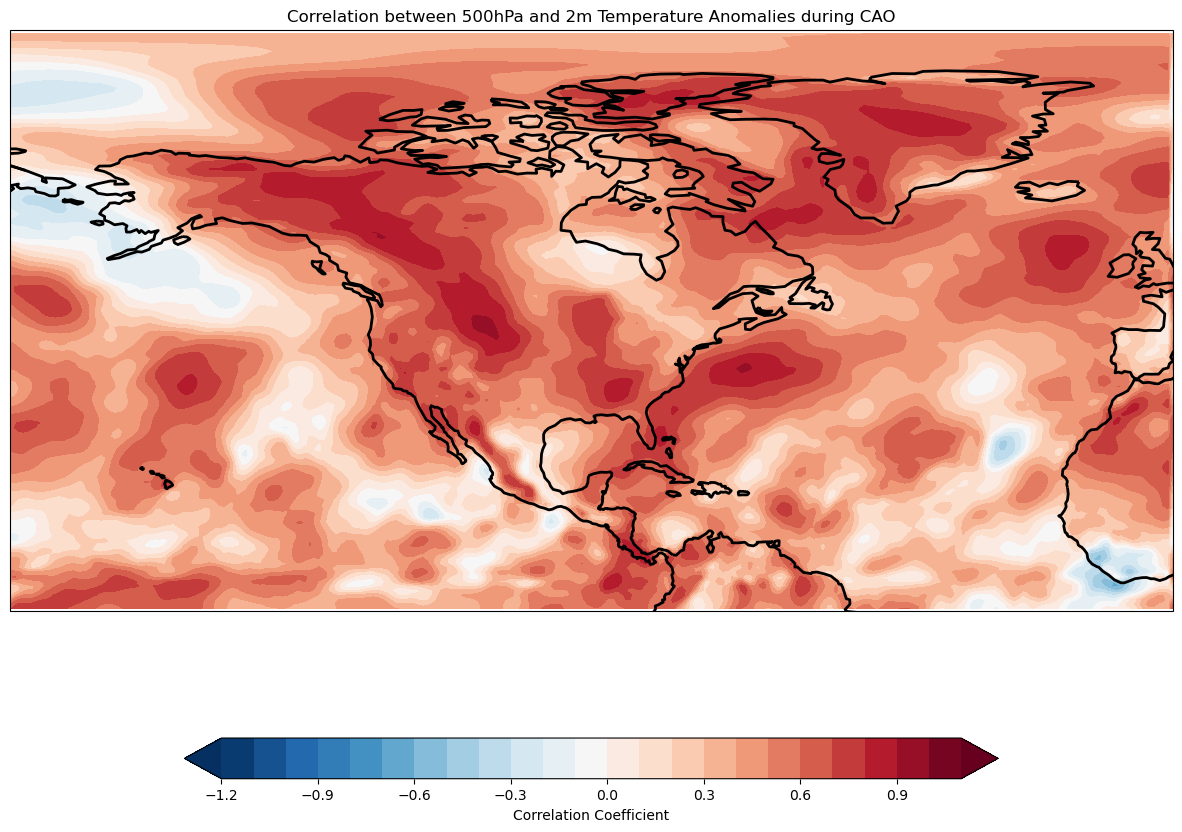

In [61]:
#Now we are plotting the 500hPa and the r map.
#I dont think it would make a major difference which data array was used. 
#Since our "main" dataset was the 500hPa dataset that was used as the "base"
#Using favorite cmap= RdBu_r
#Very red :|

clevs = np.arange(-1.2, 1.2, 0.1)

fig = plt.figure(figsize=(15, 11))

# Set the axes using the specified map projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Add cyclic point
data, lon = add_cyclic_point(r_map, coord=da_500_anoms_cao1['lon'])

# Make a filled contour plot
cs = ax.contourf(lon, da_500_anoms_cao1['lat'],
                 data, clevs,
                 transform=ccrs.PlateCarree(),
                 cmap='RdBu_r', extend='both')

# Add coastlines
ax.coastlines(linewidth= 2)

ax.set_extent([-180, 0, 90, 0], ccrs.PlateCarree())


# Call colorbar
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.7,
                    label='Correlation Coefficient')

# Add title
plt.title('Correlation between 500hPa and 2m Temperature Anomalies during CAO')
plt.show()


In [24]:
#Scipy stats package

from scipy.stats import pearsonr

In [26]:
#Now we are on the part to find significance from correlation map. 
#This part prints out a time for how it takes to calculate
#calculating the pearson coefficient and p value over each grid point

array_500 = da_500_anoms_cao1.values
array_t2m = da_t2m_anoms_cao.values

nt, ny, nx = array_t2m.shape

p_array = np.zeros((ny, nx))
r_array = np.zeros((ny, nx))

t_start = time.perf_counter()

for i in range(nx):
    for j in range(ny):
        r, p = pearsonr(array_500[:, j, i], array_t2m[:, j, i])
        r_array[j, i] = r
        p_array[j, i] = p

print(f"{time.perf_counter()-t_start:0.2f} s")

1.12 s


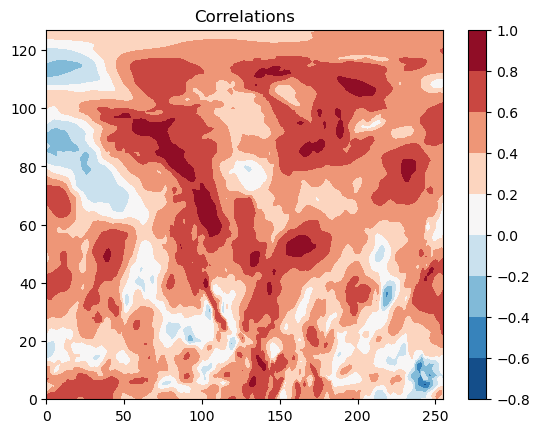

In [27]:
#Now we are plotting the correlation from the r array

plt.contourf(r_array,cmap='RdBu_r')
plt.title("Correlations")
plt.colorbar() ;

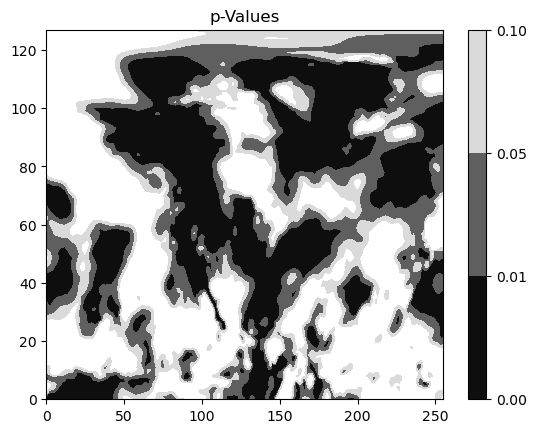

In [28]:
#Now we are plotting the p values from the p array

plt.contourf(p_array,[0,0.01,0.05,0.1],cmap='Greys_r')
plt.title("p-Values")
plt.colorbar() ;

In [29]:
#Here creating a mask with out p value being less than 5% shows our confidence in the correlation

mask_sig=np.where(p_array<0.05,r_array,np.nan)

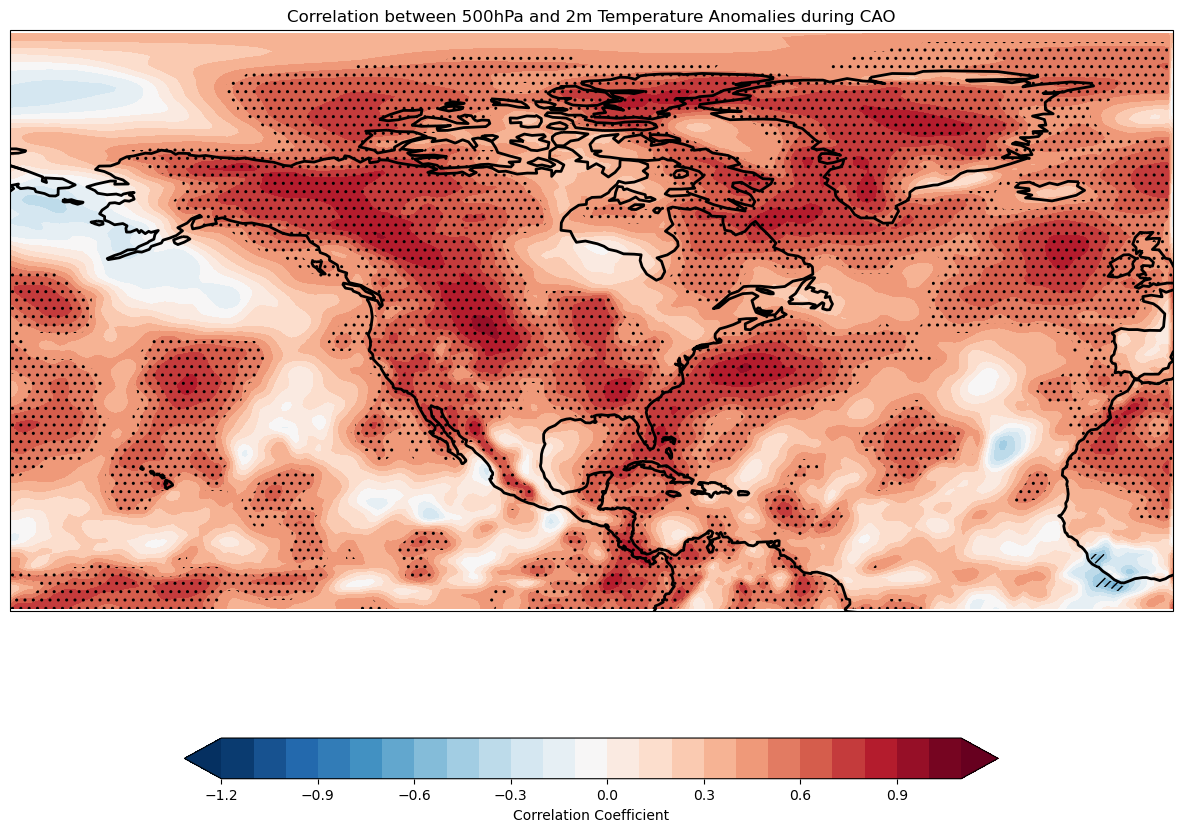

In [57]:
#Now we are plotting the correlation and p values and marking it with dots and hatches

clevs=np.arange(-1.2,1.2,0.1)

fig = plt.figure(figsize=(15,11))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree())

# Add cyclic point
data=r_array
data,lon=add_cyclic_point(data,coord=da_500_anoms_cao1['lon'])
mask_data,lons=add_cyclic_point(mask_sig,coord=da_500_anoms_cao1['lon'])

# Make a filled contour plot
cs=ax.contourf(lon,da_500_anoms_cao1['lat'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='RdBu_r',extend='both')

ax.contourf(lon,da_500_anoms_cao1['lat'],mask_data,[0,1],
            transform = ccrs.PlateCarree(),colors='None',
            hatches=['////','..'],extend='both',alpha=0)

# Add coastlines
ax.coastlines(linewidth=2)

ax.set_extent([-180, 0, 90, 0], ccrs.PlateCarree())

# Add gridlines
#ax.gridlines()

# Define the xticks for longtitude 
ax.set_xticks(np.arange(180,0,60),crs=ccrs.PlateCarree())
lon_formatter=cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define ytick for latitude
ax.set_yticks(np.arange(90,0,30),crs=ccrs.PlateCarree())
lat_formatter=cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Correlation Coefficient')

# Add title
plt.title('Correlation between 500hPa and 2m Temperature Anomalies during CAO') ;

In [31]:
# Now we testing the p value even farther to make sure its not false significance. since almost the whole map is covered

from scipy.stats import rankdata

def fdr(p_vals):
    # from https://stackoverflow.com/questions/25185205/calculating-adjusted-p-values-in-python  
    ranked_p_values = rankdata(p_vals)
    fdr = p_vals * len(p_vals) / ranked_p_values
    fdr[fdr > 1] = 1

    return fdr

In [32]:

from statsmodels.stats.multitest import fdrcorrection as fdr

# Assuming p_array is a 2D array with shape (ny, nx)
ny, nx = p_array.shape

# function expecting vector so reshape 2D p value array as vector
p_array_vec = np.ravel(p_array, order='C')

# reshape corrected p value vectore back to 2D array
p_array_corrected_vec = fdr(p_array_vec)[1]

# Reshape corrected p value vector back to 2D array
p_array_corrected = np.reshape(p_array_corrected_vec, (ny, nx), order='C')




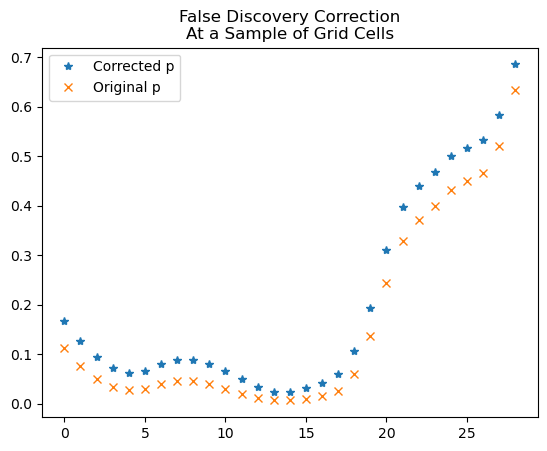

In [33]:
#Plotting it on a 2d graph

plt.plot(p_array_corrected_vec[5170:5199],'*')
plt.plot(p_array_vec[5170:5199],'x') 
plt.legend(['Corrected p','Original p'])
plt.title("False Discovery Correction\nAt a Sample of Grid Cells") ;

Text(0.5, 1.0, 'Correlation between 500hPa and 2m Temperature during CAO')

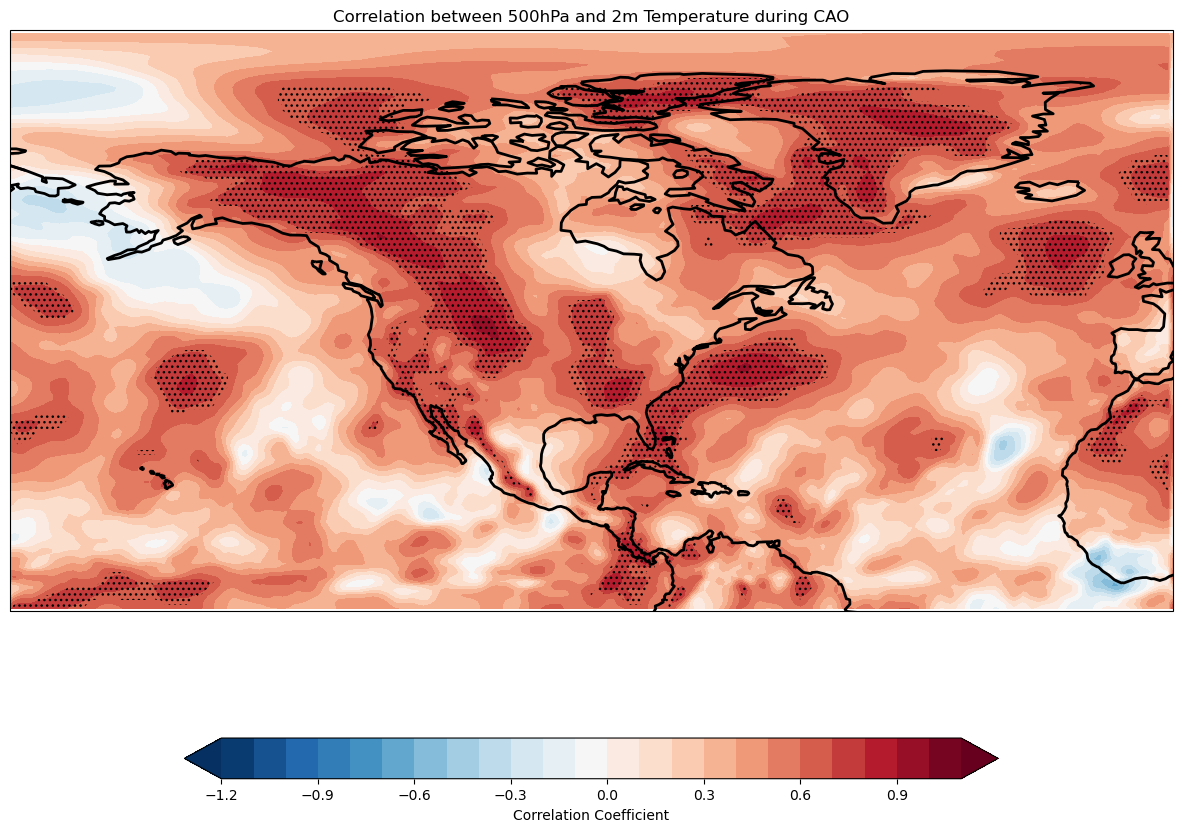

In [59]:
# Create a mask based on a significance threshold 
# And plotting it to see if anything changed and show the very significant areas

mask_sig2 = np.where(p_array_corrected < 0.01, r_array, np.nan)

clevs=np.arange(-1.2,1.2,0.1)

fig = plt.figure(figsize=(15,11))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree())

# Add cyclic point
data=r_array
data,lon=add_cyclic_point(data,coord=da_500_anoms_cao1['lon'])
mask_data,lons=add_cyclic_point(mask_sig2,coord=da_500_anoms_cao1['lon'])

# Make a filled contour plot
cs=ax.contourf(lon,da_500_anoms_cao1['lat'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='RdBu_r',extend='both')

ax.contourf(lon,da_500_anoms_cao1['lat'],mask_data,[0,1],
            transform = ccrs.PlateCarree(),colors='None',
            hatches=['//','...'],extend='both',alpha=0)

# Add coastlines
ax.coastlines(linewidth=2)


ax.set_extent([-180, 0, 90, 0], ccrs.PlateCarree())


# Define the xticks for longtitude 
ax.set_xticks(np.arange(180,0,60),crs=ccrs.PlateCarree())
lon_formatter=cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define ytick for latitude
ax.set_yticks(np.arange(90,0,30),crs=ccrs.PlateCarree())
lat_formatter=cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Correlation Coefficient')

# Add title
plt.title('Correlation between 500hPa and 2m Temperature during CAO')